## JH MODEL 6
# Changes=
After looking at other's examples I see that increasing the Dense operation will make a more densely connected NN layer, giving a higher accuracy in the end. Not sure why I assumed it had to remain the shape of our data.
1. inputs = Input(shape=(features.shape[1], ))
- x = Dense(500, activation='elu')(inputs)
- x = BatchNormalization()(x)  
- x = Dense(100, activation='elu')(x)
- x = BatchNormalization()(x) 
- x = Dense(50, activation='elu')(x)
- x = BatchNormalization()(x) 
- x = Dropout(0.1)(x)
- x = Dense(1, activation='linear')(x)
2. model.compile(optimizer='adadelta', loss='mse')

# Results=
 - Train R^2 = 0.90609109528
 - Test  R^2 = 0.697707210312

In [1]:
import pandas as pd


NameError: name 'Sequential' is not defined

In [36]:
filename = 'C:/MSDS/MachL/Wk5/hour.csv'
# parse dates will convert those columns (labels in the list) to dates

# infer datetime format will try to figure out the datetime format of the dates columns
# and keep using that for the column, so can speed up loading by a lot sometimes
bike_df = pd.read_csv(filename, parse_dates=['dteday'], infer_datetime_format=True)
bike_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [37]:
# drops the record index 'instant' and date
# also drop casual and registered, because cnt = casual + registered
drop_cols = ['instant', 'dteday', 'casual', 'registered']
bike_df.drop(drop_cols, axis=1, inplace=True)
# if you want, you could engineer more features by getting the day of the month or other properties from the date

In [38]:
cols = bike_df.columns
feat_cols = [c for c in cols if c != 'cnt']
features = bike_df[feat_cols].values
targets = bike_df['cnt'].values

# for time series we typically want to save the last bit as the testing instead of mixing up the timesteps
trainsize = round(0.8 * features.shape[0])
train_features = features[:trainsize]
test_features = features[trainsize:]
train_targets = targets[:trainsize]
test_targets = targets[trainsize:]
print(train_targets.shape)
print(test_targets.shape)

(13903,)
(3476,)


In [39]:
# force to use CPU for testing
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [40]:
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.models import Model, load_model
import keras.backend as K
from keras.callbacks import ModelCheckpoint

In [41]:
features.shape

(17379, 12)

In [42]:
# creates the model

# restart keras session (clear weights), sometimes this will clear up errors
#import keras.backend as K
K.clear_session()
# change dense to 20, with a dropout of .05 and use relu activation
inputs = Input(shape=(features.shape[1], ))
x = Dense(500, activation='elu')(inputs)
x = BatchNormalization()(x)  
x = Dense(100, activation='elu')(x)
x = BatchNormalization()(x) 
x = Dense(50, activation='elu')(x)
x = BatchNormalization()(x)  # batchnorm basically makes the net fit faster at a higher accuracy
x = Dropout(0.1)(x)
x = Dense(1, activation='linear')(x)

In [43]:
# this saves the best model (lowest validation loss)
checkpoint = ModelCheckpoint('3_layer_dense.h5', monitor='val_loss', save_best_only=True)
cb = [checkpoint]

# this compiles our model so it is ready to fit
model = Model(inputs, x)
model.compile(optimizer='adadelta', loss='mse')

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               6500      
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
batch_normalization_3 (Batch (None, 50)                200       
__________

In [45]:
subset_size = trainsize
train_feature_subset = train_features[:subset_size]
train_target_subset = train_targets[:subset_size]
# we actually fit the model here
history = model.fit(train_feature_subset,
                    train_target_subset,
                    epochs=300,
                    validation_split=0.15,
                    callbacks=cb,
                    batch_size=56,
                   verbose = 0)

In [46]:
#model.summary()
#model.get_config()

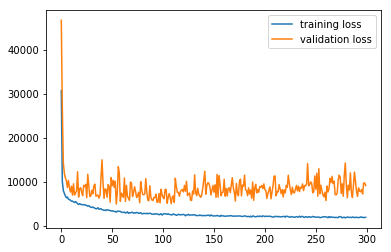

In [53]:
# check losses for overfitting and performance
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()

0.0
0.90609109528


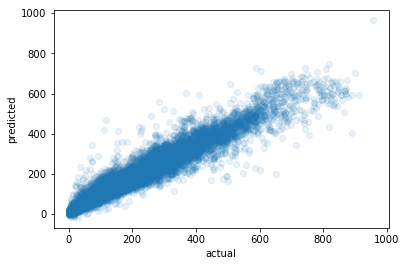

In [54]:
past_preds = model.predict(train_features)[:, 0]
future_preds = model.predict(test_features)[:, 0]

from sklearn.metrics import r2_score
import numpy as np

# our benchmark is just guessing the average
benchmark = np.mean(train_targets)
print(r2_score(train_targets, [benchmark] * train_targets.shape[0]))

print(r2_score(train_targets, past_preds))
plt.scatter(train_targets, past_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

-0.112995264662
0.697707210312


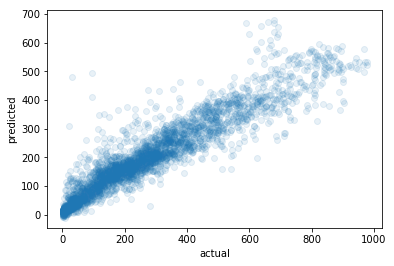

In [55]:
print(r2_score(test_targets, [benchmark] * test_targets.shape[0]))

print(r2_score(test_targets, future_preds))
plt.scatter(test_targets, future_preds, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

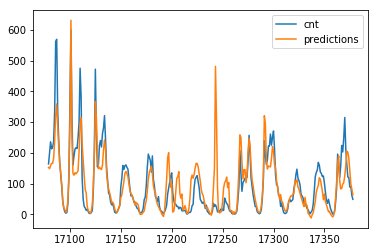

In [56]:
bike_df['cnt'].iloc[-300:].plot()
plt.plot(bike_df.index[-300:], future_preds[-300:], label='predictions')
_ = plt.legend()

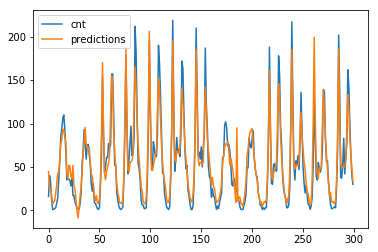

In [57]:
bike_df['cnt'].iloc[:300].plot()
plt.plot(bike_df.index[:300], past_preds[:300], label='predictions')
_ = plt.legend()